In [ ]:
## 전이학습
#파이토치 제공 전이학습
#pytorch.org/docs/

import torchvision.models as models
# imageNet

#Network Architecture

#LeNet


#AlexNet
alexnet=models.alexnet(pretrained=True)

#VGG
vgg16=models.vgg16(pretrained=True)

#GoogLeNet
googlenet=models.googlenet(pretrained=True)

#ResNet
resnet18=models.resnet18(pretrained=True)

#DenseNet
densnet=models.densenet161(pretrained=True)



Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


NameError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [ ]:
if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')
print('Using PyTorch version:', torch.__version__, 'Device:',DEVICE)

Using PyTorch version: 1.8.1+cu101 Device: cpu


In [ ]:
BATCH_SIZE=32
EPOCHS=10


In [ ]:
train_dataset=datasets.CIFAR10(root='../data/CIFAR_10',
                               train=True,
                               download=True,
                               transform=transforms.Compose([
                                                            transforms.RandomHorizontalFlip(),
                                                             transforms.ToTensor(),
                                                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]))
test_dataset=datasets.CIFAR10(root='../data/CIFAR_10',
                              train=False,
                              transform=transforms.Compose([
                                                            transforms.RandomHorizontalFlip(),
                                                            transforms.ToTensor(),
                                                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                              ]))
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)


Extracting ../data/CIFAR_10/cifar-10-python.tar.gz to ../data/CIFAR_10


In [ ]:
for (X_train,y_train) in train_loader:
  print('X_train:',X_train.size(),'type:',X_train.type())
  print('y_train:',y_train.size(),'type:',y_train.type())
  break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

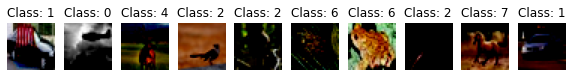

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))

for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(np.transpose(X_train[i],(1,2,0)))
  plt.title('Class: '+str(y_train[i].item()))

In [ ]:
# ResNet 모델 설계
''' ResNet 모델은 내부에 반복적으로 이용하는 Block을 바탕으로 구성되어 있다.
    반복적으로 이용하는 block을 먼저 정의한 후 정의된 block을 바탕으로 Resnet을 구현한다.
'''
class BasicBlock(nn.Module):

  
    def __init__(self, in_planes, planes, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(planes))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 16
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(16, 2, stride = 1)
        self.layer2 = self._make_layer(32, 2, stride = 2)
        self.layer3 = self._make_layer(64, 2, stride = 2)
        self.linear = nn.Linear(64, num_classes)
        
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks  - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [ ]:
model = ResNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=

In [ ]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
                epoch, batch_idx * len(image), 
                len(train_loader.dataset), 100. * batch_idx / len(train_loader), 
                loss.item()))

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= (len(test_loader.dataset) / BATCH_SIZE)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

In [ ]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".format(
        epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/50000 (0%)]	Train Loss: 2.385712
Train Epoch: 1 [6400/50000 (13%)]	Train Loss: 1.883025
Train Epoch: 1 [12800/50000 (26%)]	Train Loss: 1.600012
Train Epoch: 1 [19200/50000 (38%)]	Train Loss: 1.459298
Train Epoch: 1 [25600/50000 (51%)]	Train Loss: 1.413128
Train Epoch: 1 [32000/50000 (64%)]	Train Loss: 0.884430
Train Epoch: 1 [38400/50000 (77%)]	Train Loss: 1.121423
Train Epoch: 1 [44800/50000 (90%)]	Train Loss: 1.019912

[EPOCH: 1], 	Test Loss: 1.2354, 	Test Accuracy: 57.13 % 

Train Epoch: 2 [0/50000 (0%)]	Train Loss: 0.782241
Train Epoch: 2 [6400/50000 (13%)]	Train Loss: 1.251102
Train Epoch: 2 [12800/50000 (26%)]	Train Loss: 0.905652
Train Epoch: 2 [19200/50000 (38%)]	Train Loss: 0.922403
Train Epoch: 2 [25600/50000 (51%)]	Train Loss: 0.770442
Train Epoch: 2 [32000/50000 (64%)]	Train Loss: 0.589756
Train Epoch: 2 [38400/50000 (77%)]	Train Loss: 0.961568
Train Epoch: 2 [44800/50000 (90%)]	Train Loss: 0.842347

[EPOCH: 2], 	Test Loss: 0.8291, 	Test Accuracy: 71.03 % 